In [51]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from scipy.integrate import quad

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
#import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
#from suntimes import SunTimes  
import sys
sys.path.append("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\optimisation_experiments")
from optimise_GDD_fctns import *
from nn_response_fctns import *

In [2]:
skip = 1
numsteps = int(163 // skip)
#ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024_full.csv')
#ds_inputs_DE1[[f't2max at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE1[[f't2min at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')

#ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], axis = 0)
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_full.csv')
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 40]
new_series = []
ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values
ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]].values
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp'
    data = ds_inputs_DE[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    #if variable_name != 't2m' and variable_name != 'photoperiod':
    #    scaler = StandardScaler()
    #    scaler.fit(data)
    #    data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'].values for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

#NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype(int).values).unsqueeze(1)
#NDVI_labels_DE = 100 - torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

27153
27153


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_11972\356867199.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_34s6o8i12c\croot\libtorch_1751464457133\work\torch\csrc\utils\tensor_new.cpp:257.)
  year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T


In [38]:
def split_ds_by_AEZ5(ds):
    ds_semiarid_low = ds.loc[ds['AEZ'].isin([1])].groupby(['Stations_id', 'year']).head(2)
    ds_arid_low = ds.loc[ds['AEZ'].isin([26, 29])].groupby(['Stations_id', 'year']).head(2)
    ds_subhumid_low = ds.loc[ds['AEZ'].isin([2])].groupby(['Stations_id', 'year']).head(2)
    ds_humid_low = ds.loc[ds['AEZ'].isin([3])].groupby(['Stations_id', 'year']).head(2)
    ds_arid_high = ds.loc[ds['AEZ'].isin([4])].groupby(['Stations_id', 'year']).head(2)
    ds_humid_high = ds.loc[ds['AEZ'].isin([5])].groupby(['Stations_id', 'year']).head(2)
    ds_cool = ds.loc[ds['AEZ'].isin([10, 11, 14])].groupby(['Stations_id', 'year']).head(2)
    print(#f'\nnum cool: {len(ds_cool)}',
        f'\nnum semiarid low: {len(ds_semiarid_low)}',
        f'\nnum arid high: {len(ds_arid_high)}',
        f'\nnum humid low: {len(ds_humid_low)}',
        f'\nnum subhumid low: {len(ds_subhumid_low)}',
        f'\nnum subhumid high: {len(ds_humid_high)}')
    ds_dict = {#'cool': ds_cool,
               'semiarid low': ds_semiarid_low,
               'arid high': ds_arid_high,
               'humid low': ds_humid_low,
               'subhumid low': ds_subhumid_low,
               'humid high': ds_humid_high}
    return ds_dict

ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties_fixed_vpd.csv')
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 105]
#ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] > 20]
ds_sites_AEZ2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\EIL_site_latlon_with_AEZ_filled.csv')
ds_inputs_SSA = ds_inputs_SSA.merge(ds_sites_AEZ2.rename(columns = {'LocationID': 'Stations_id'})[['Stations_id', 'AEZ2']], on='Stations_id', how='left')
ds_inputs_SSA['AEZ'] = ds_inputs_SSA['AEZ2']
ds_inputs_SSA = ds_inputs_SSA.rename(columns={'Referenzjahr': 'year'})
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['lat'] > -25]

ds_SSA_early = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'EPOP')|(ds_inputs_SSA['vargroup'] == 'EIHY')].reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
early_ds_dict = split_ds_by_AEZ5(ds_SSA_early)

ds_SSA_late = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'ILPO')|(ds_inputs_SSA['vargroup'] == 'ILHY')].reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
late_ds_dict = split_ds_by_AEZ5(ds_SSA_late)

combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}

X_tensor_train, y_tensor_train = ML_tensor_from_ds(combined_variety_tests_dict['semiarid low'])


num semiarid low: 120 
num arid high: 59 
num humid low: 26 
num subhumid low: 67 
num subhumid high: 45

num semiarid low: 101 
num arid high: 50 
num humid low: 17 
num subhumid low: 68 
num subhumid high: 46


In [52]:
n_channels = 5
train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2023, 2024], year_column = -2, bs = 30000, n_channels = n_channels, train_proportion=0.8)
train_dl, val_dl = train_test_dl_from_tensors(X_tensor_train, y_tensor_train, bs = 30000, n_channels = n_channels, train_proportion=0.99)
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16#day2 -> 8#day -> 16 #day3 ->4
num_layers = 4#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False
KG2 = True
save_name = 'NN_response_DE_no_day5'
#save_name = 'KFold1'
model= nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG=KG, KG2=KG2)
model = load_model(save_name, model)

In [53]:
def forward_NN(self, x0):
    x = x0[:, :, :self.input_dim]
    original_temp = x0[:, :, [0]]
    for i, linlayer in enumerate(self.layers_list[:self.num_layers]):
        x = linlayer(x)
        x = self.activation(x)
        #print(x.shape)
    # Classify all layers using fully connected layer
    out_space = torch.abs(self.fc(x))*(original_temp >5)#*(x[:, :, [0]] >5) # (batch, output_dim)

    #print(out_scores.max())
    return out_space

In [54]:
def forward_NN_KG2(self, x0):
    with torch.no_grad():
        T_min = 9 + 10*(torch.tanh(self.u1)) - 4 #normally multiplier = 2
        T_opt = 28 + 7*(torch.tanh(self.u2)) - 4 #normally multiplier = 3
        T_max = 39 + 3.5*torch.tanh(self.u3)#normally no multiplier
        #print(T_opt)
        #print(T_min)
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        original_temp = x0[:, :, [0]]
        x2 = x0[:, :, [0]]
        x2[:, :, 0] = (x2[:, :, 0] <= T_max) * ( (2*(((x2[:, :, 0] - T_min)*(x2[:, :, 0] >= T_min) + (x2[:, :, 0] <= T_min).float()).pow(alpha))*(x2[:, :, 0] >= T_min))*((T_opt - T_min).pow(alpha)) - ((((x2[:, :, 0] - T_min)*(x2[:, :, 0] >= T_min) + (x2[:, :, 0] <= T_min).float()).pow(2*alpha))*(x2[:, :, 0] >= T_min)) ) / ((T_opt - T_min).pow(2*alpha))
        x = x0[:, :, :self.input_dim]
        for linlayer in self.layers_list[:self.num_layers]:
            x = linlayer(x)
            x = self.activation(x)
        out_space = self.u4*torch.abs(self.fc(x) + x2)*(original_temp >5)#*(x[:, :, [0]] >5) # (batch, output_dim)

    #print(out_scores.max())
    return out_space - self.u4*x2, self.u4*x2

In [34]:
input_x[0, :, 20]

tensor([10.0000, 15.0000,  5.0000, 14.8586, -5.7641, 98.0000,  1.0000,  1.0000])

In [15]:
for experiment_index in range(5):
    sample_index = np.random.randint(0, input_tensor.shape[0])
    day_index = np.random.randint(0, temp_NDVI_series_DE.shape[2])
    input_x[0, 1, :] = input_tensor[sample_index, 1, day_index]
    input_x[0, 2, :] = input_tensor[sample_index, 2, day_index]
    input_x[0, 3, :] = input_tensor[sample_index, 3, day_index]
    input_x[0, 4, :] = input_tensor[sample_index, 4, day_index]
    input_x[0, 5, :] = input_tensor[sample_index, 5, day_index]
    print(input_x[0, :, 0])
    with torch.no_grad():
        print(trained_model.forward(input_x.transpose(1, 2)).shape)

tensor([ 0.0000,  1.4922,  2.3167, 11.9333, -1.6201, 15.1000,  1.0000,  1.0000])


NameError: name 'trained_model' is not defined

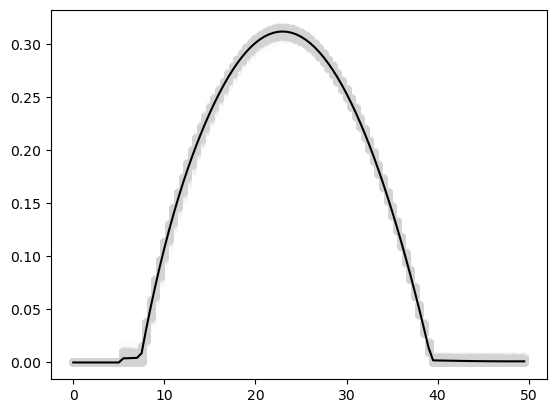

In [55]:
fig, ax = plt.subplots()
input_tensor = temp_NDVI_series_DE
#input_tensor = X_tensor_train
input_x = torch.ones((1, 8, 100))
for vble_index in range(0, 5):
    input_x[0, vble_index, :] = input_tensor[:, vble_index, :].mean()#.quantile(0.75)
for i, T in enumerate(np.arange(0, 50, 0.5)):
    input_x[0, 0, i] = T
#    input_x[0, 1, i] = T + 5
#    input_x[0, 2, i] = T - 5
#for i, T in enumerate(np.linspace(-0.3, 0, 100)):#np.arange(-0.3, 0, 0.05)):
#    input_x[0, 4, i] = T
#    input_x[0, 4, i] = T + 0.05
#    input_x[0, 5, i] = T - 0.05
#for i, day in enumerate(np.arange(0, 100, 1)):
#    input_x[0, 5, i] = day
vals_list = []
for experiment_index in range(500):
    sample_index = np.random.randint(0, input_tensor.shape[0])
    day_index = np.random.randint(0, temp_NDVI_series_DE.shape[2])
    input_x[0, 1, :] = input_tensor[sample_index, 1, day_index]
    input_x[0, 2, :] = input_tensor[sample_index, 2, day_index]
    input_x[0, 3, :] = input_tensor[sample_index, 3, day_index]
    input_x[0, 4, :] = input_tensor[sample_index, 4, day_index]
    input_x[0, 5, :] = input_tensor[sample_index, 5, day_index]
    #print(input_x[0, 1, 0], input_x[0, 2, 0],input_x[0, 3, 0], input_x[0, 4, 0], input_x[0, 5, 0])
    #temp_pert = np.abs(np.random.normal(0, 1)*5)
    #temp_pert = input_tensor[sample_index, 1, day_index] - input_tensor[sample_index, 0, day_index]
    #if experiment_index % 50 == 0:
    #    print(temp_pert)
    #input_x[0, 1, :] = input_x[0, 0, :] + temp_pert
    #input_x[0, 2, :] = input_x[0, 0, :] - temp_pert
    with torch.no_grad():
        vals, x2 = forward_NN_KG2(model, input_x.transpose(1, 2))
        #print(vals)
    vals_list.append(vals.numpy().squeeze())
    ax.scatter(np.arange(0, 50, 0.5), vals.numpy().squeeze() + x2.squeeze().numpy(), color = 'lightgrey', alpha = 0.005)# + x2.squeeze().numpy()
for vble_index in range(3, 6):
    input_x[0, vble_index, :] = input_tensor[:, vble_index, :].mean()#.quantile(0.75)
input_x[0, 5, :] = day_index
temp_pert = 5#np.abs(np.random.normal(0, 1)*10)
input_x[0, 1, :] = input_x[0, 0, :] + temp_pert
input_x[0, 2, :] = input_x[0, 0, :] - temp_pert
with torch.no_grad():
    vals, x2 = forward_NN_KG2(model, input_x.transpose(1, 2))
#vals = np.array(vals).squeeze()
vals = np.mean(np.array(vals_list), axis=0)
vals_spread = np.std(np.array(vals_list), axis=0)
vals_LQ = np.quantile(np.array(vals_list), 0.1, axis=0)
vals_UQ = np.quantile(np.array(vals_list), 0.9, axis=0)
#ax.fill_between(np.arange(0, 50, 0.5), vals - vals_spread, vals + vals_spread, color = 'lightgrey', label = 'spread due to other variables')
#ax.fill_between(np.arange(0, 50, 0.5), vals_LQ + x2.squeeze().numpy(), vals_UQ + x2.squeeze().numpy(), color = 'lightgrey', label = 'spread due to other variables')
ax.plot(np.arange(0, 50, 0.5), np.array(vals)  + x2.squeeze().numpy(), color = 'black', label = 'mean response')
#ax.axvline(5)
#ax.fill_between(np.arange(0, 50, 0.5), vals_LQ, vals_UQ, color = 'lightgrey', label = 'spread due to other variables')
#ax.plot(np.arange(0, 50, 0.5), np.array(vals), color = 'black', label = 'mean response')
#ax.plot(np.arange(0, 50, 0.5), x2.squeeze(), color = 'blue', label = 'mwang resp')
#plt.plot(np.arange(0, 50, 0.5), np.array(vals).squeeze()*2)#np.linspace(-0.3, 0, 100)

Text(0.5, 1.0, 'Wang response functions with experimental parameters\nvs. neural network response')

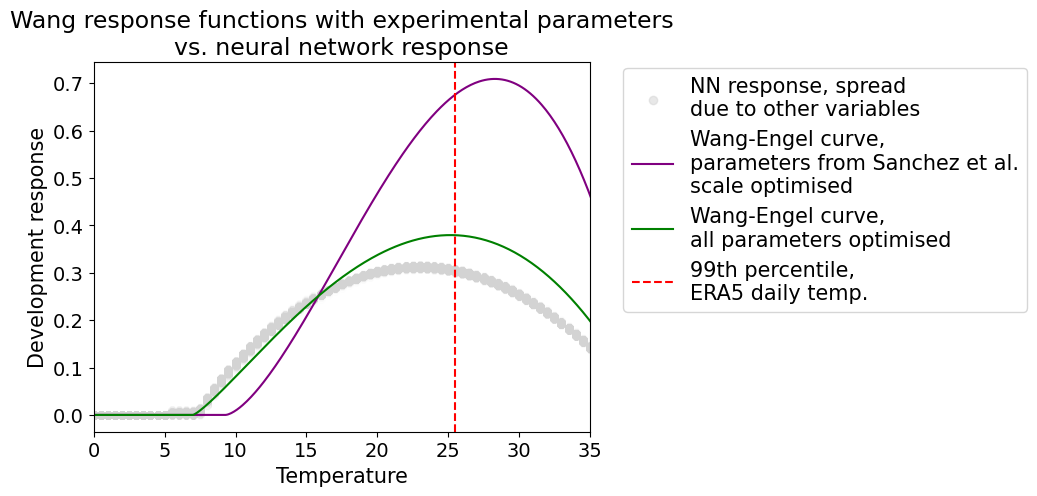

In [56]:
font_size = 15
fm_flowering_all_DE2 = [[[0.503004, 9.3, 28.3, 39.2]], 'ds_inputs_DE_reduced', 0]#[[[0.503004, 7.02058042, 27.00252239, 39.30655295]], 'ds_inputs_DE_reduced', 0]
x = fm_flowering_all_DE2[0][0]
x_0 = 0.708822
x_1 = 0.607894
#x_1 = 0.4
fm_flowering_all_DE = [[0.37934956, 7.0094127, 25.16467337, 39.17442218], 'ds_inputs_DE_reduced', 0]#[[ 0.37934956  7.0094127  25.16467337 39.17442218  2.5360532   4.80742285], 'ds_inputs_DE_reduced', 0]
table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), 8, 3)#, x[4], x[5])#x[2]
def response(meantemp):
    return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
input_tensor = temp_NDVI_series_DE
input_x = torch.ones((1, 8, 100))
for i, T in enumerate(np.arange(0, 50, 0.5)):
    input_x[0, 0, i] = T
vals_list = []
for experiment_index in range(100):
    sample_index = np.random.randint(0, input_tensor.shape[0])
    day_index = np.random.randint(0, temp_NDVI_series_DE.shape[2])
    input_x[0, 1, :] = input_tensor[sample_index, 1, day_index]
    input_x[0, 2, :] = input_tensor[sample_index, 2, day_index]
    input_x[0, 3, :] = input_tensor[sample_index, 3, day_index]
    input_x[0, 4, :] = input_tensor[sample_index, 4, day_index]
    input_x[0, 5, :] = input_tensor[sample_index, 5, day_index]
    with torch.no_grad():
        vals, x2 = forward_NN_KG2(model, input_x.transpose(1, 2))
    vals_list.append(vals.numpy().squeeze())
    if experiment_index == 0:
        ax.scatter(np.arange(0, 50, 0.5), vals.numpy().squeeze() + x2.squeeze().numpy(), color = 'lightgrey', alpha = 0.005)#, label='NN response, spread\ndue to other variables')
    else:
        ax.scatter(np.arange(0, 50, 0.5), vals.numpy().squeeze() + x2.squeeze().numpy(), color = 'lightgrey', alpha = 0.005)
ax.scatter([], [], color = 'lightgrey', alpha = 0.5, label='NN response, spread\ndue to other variables')
vals = np.mean(np.array(vals_list), axis=0)
vals_spread = np.std(np.array(vals_list), axis=0)
vals_LQ = np.quantile(np.array(vals_list), 0.1, axis=0)
vals_UQ = np.quantile(np.array(vals_list), 0.9, axis=0)
#ax.plot(np.arange(0, 50, 0.5), np.array(vals) + x2.squeeze().numpy() , color = 'black', label = 'mean response')
ax.plot(xvals, x_0*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3]), 
        label = 'Wang-Engel curve,\nparameters from Sanchez et al.\nscale optimised', color='Purple')#fm_flowering_all_DE2[0][0][0]
ax.plot(xvals, fm_flowering_all_DE[0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][1], fm_flowering_all_DE[0][2], fm_flowering_all_DE[0][3]), 
        label = 'Wang-Engel curve,\nall parameters optimised', color='Green')
#ax.fill_between(np.arange(0, 50, 0.5), vals_LQ + x2.squeeze().numpy(), vals_UQ+ x2.squeeze().numpy(), color = 'lightgrey', label = 'NN response, spread\ndue to other variables')

ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99), color = 'red', linestyle = '--', label = '99th percentile,\nERA5 daily temp.')
ax.set_xlim(0, 35)
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.set_xlabel('Temperature', fontsize = font_size)
ax.set_ylabel('Development response', fontsize = font_size)
fig.legend(bbox_to_anchor=(1.6, 0.89), fontsize = font_size)
ax.set_title('Wang response functions with experimental parameters\nvs. neural network response', fontsize = font_size + 2)

Text(0.5, 1.0, 'Wang response functions with experimental parameters\nvs. neural network response')

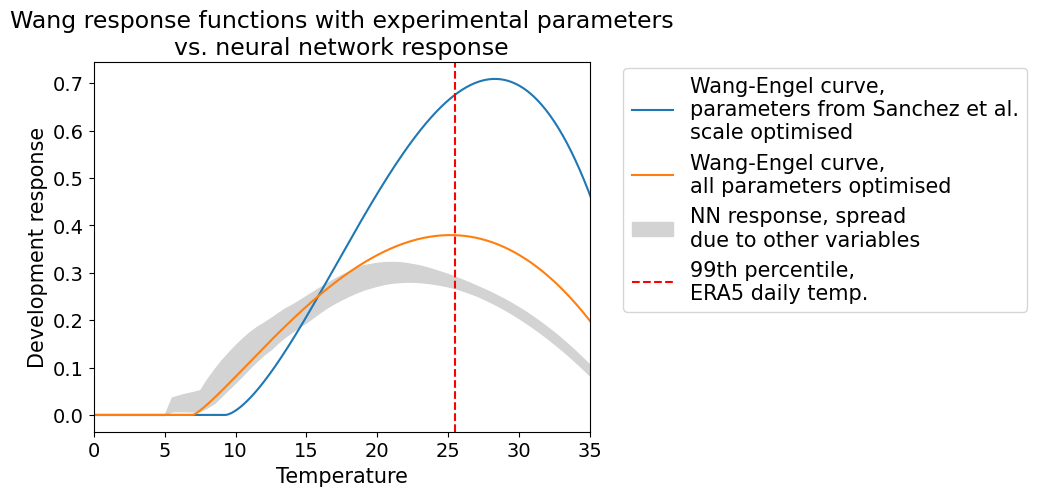

In [ ]:
font_size = 15
fm_flowering_all_DE2 = [[[0.503004, 9.3, 28.3, 39.2]], 'ds_inputs_DE_reduced', 0]#[[[0.503004, 7.02058042, 27.00252239, 39.30655295]], 'ds_inputs_DE_reduced', 0]
x = fm_flowering_all_DE2[0][0]
x_0 = 0.708822
x_1 = 0.607894
#x_1 = 0.4
fm_flowering_all_DE = [[0.37934956, 7.0094127, 25.16467337, 39.17442218], 'ds_inputs_DE_reduced', 0]#[[ 0.37934956  7.0094127  25.16467337 39.17442218  2.5360532   4.80742285], 'ds_inputs_DE_reduced', 0]
table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), 8, 3)#, x[4], x[5])#x[2]
def response(meantemp):
    return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
ax.plot(xvals, x_0*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3]), label = 'Wang-Engel curve,\nparameters from Sanchez et al.\nscale optimised')#fm_flowering_all_DE2[0][0][0]
#ax.plot(np.arange(0, 50, 0.5), x_1*np.array(table), label = 'Convolved Wang-Engel curve,\nparameters from Sanchez et al.\nscale optimised')
ax.plot(xvals, fm_flowering_all_DE[0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][1], fm_flowering_all_DE[0][2], fm_flowering_all_DE[0][3]), label = 'Wang-Engel curve,\nall parameters optimised')
#ax.plot(np.arange(0, 50, 0.5), vals, label = 'Neural network response with\nother variables held constant')
#ax.fill_between(np.arange(0, 50, 0.5), vals - vals_spread , vals + vals_spread, color = 'lightgrey', label = 'NN response inc. spread\ndue to other variables')
ax.fill_between(np.arange(0, 50, 0.5), vals_LQ + x2.squeeze().numpy(), vals_UQ+ x2.squeeze().numpy(), color = 'lightgrey', label = 'NN response, spread\ndue to other variables')
#ax.set_title('Convolution SD in box of 7, temp range in day of 6')

ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99), color = 'red', linestyle = '--', label = '99th percentile,\nERA5 daily temp.')
#ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.05), color = 'red', linestyle = '--', label = '1st percentile,\nERA5 daily temp.')
#ax.axvline(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values.max(), color = 'red', linestyle = ':', label = '99th percentile,\nERA5 daily temp.')
#ax.axvline(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values.min(), color = 'red', linestyle = ':', label = '1st percentile,\nERA5 daily temp.')
#ax.axvline(ds_inputs_DE['t2m at day 88'].mean(), color = 'red', linestyle = ':', label = 'Mean temp at mean day of flowering')
#ax.axvline(28.3, color = 'k', linestyle = '--', label = 'optimal temp from\nSanchez et al.')
#ax.axvline(fm_flowering_all_DE[0][2], color = 'k', label = 'optimal temp from optimisation')
ax.set_xlim(0, 35)
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.set_xlabel('Temperature', fontsize = font_size)
ax.set_ylabel('Development response', fontsize = font_size)
fig.legend(bbox_to_anchor=(1.6, 0.89), fontsize = font_size)
ax.set_title('Wang response functions with experimental parameters\nvs. neural network response', fontsize = font_size + 2)


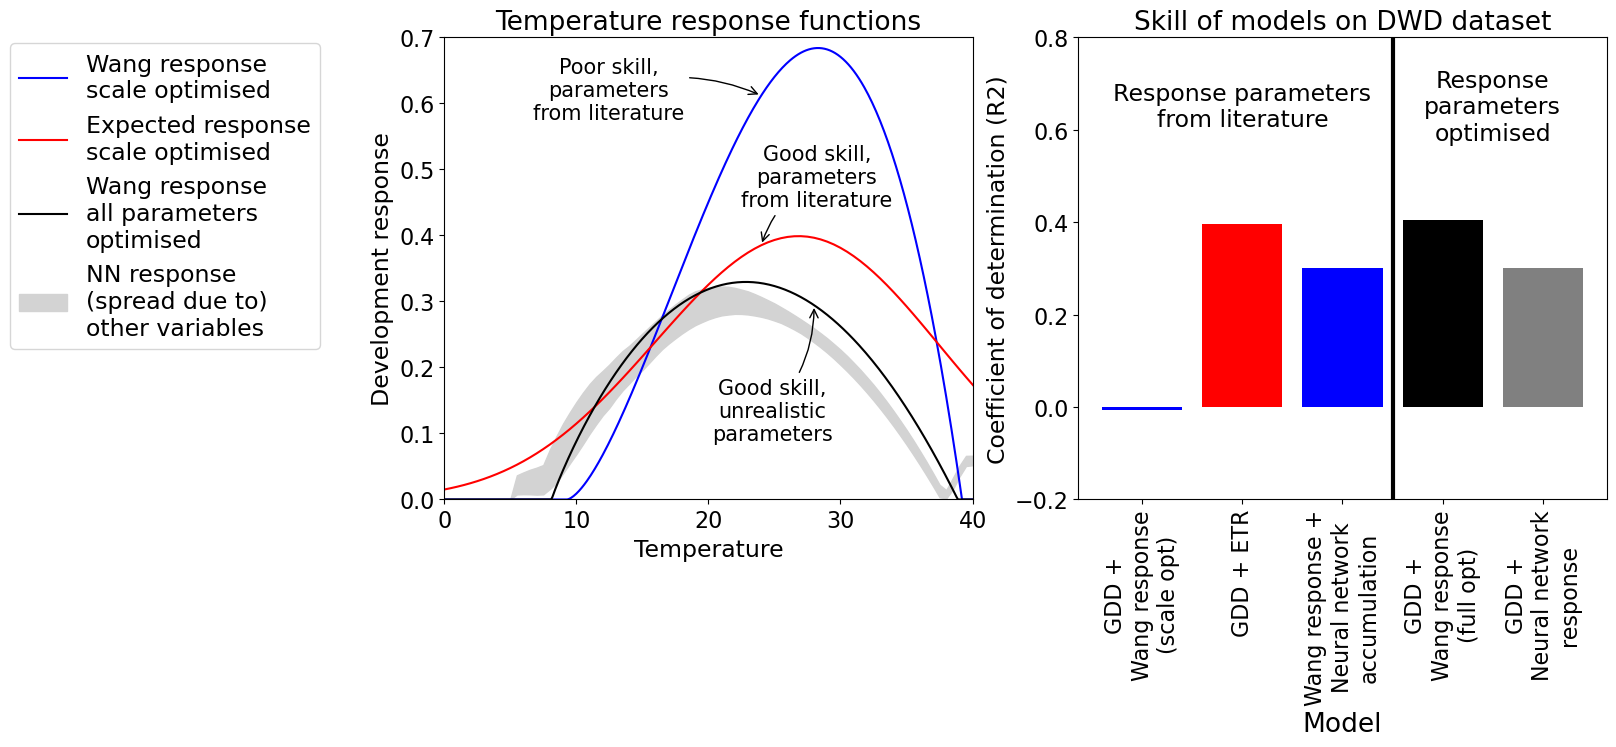

In [ ]:
font_size = 17
x_1 = 0.684018
x_3 = 0.329584
x_0_conv =  0.587931
table = vec_expint(9.3, 28.3, 39.2, np.arange(0, 50, 0.5), 8, 3)#, x[4], x[5])#x[2]
fm_flowering_all_DE2 = [[[x_1, 9.3, 28.3, 39.2]], 'ds_inputs_DE_reduced', 0]#[[[0.503004, 7.02058042, 27.00252239, 39.30655295]], 'ds_inputs_DE_reduced', 0]
fm_flowering_all_DE = [[[x_3, 8.13380267, 22.83931163, 38.88095627], ds_inputs_DE, 0]]#[[[0.34525542, 7.00219008, 23.57229066, 39.02041395]], ds_inputs_DE, 0]
x = fm_flowering_all_DE2[0][0]
xvals = np.arange(0, 50, 0.1)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
ax = axs[0]
ax.plot(xvals, x[0]*modelling_fctns.Wang_Engel_Temp_response(xvals, x[1], x[2], x[3]), label = 'Wang response\nscale optimised', color = 'blue')#linestyle = '-.', color = 'k'fm_flowering_all_DE2[0][0][0] \nSanchez parameters,
ax.plot(np.arange(0, 50, 0.5), x_0_conv*table, label = 'Expected response\nscale optimised', color = 'red')#\nSanchez parameters
ax.plot(xvals, fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3]), 
        label = 'Wang response\nall parameters\noptimised', color='k')
ax.fill_between(np.arange(0, 50, 0.5), vals_LQ + x2.squeeze().numpy(), vals_UQ + x2.squeeze().numpy(), color = 'lightgrey', label = 'NN response\n(spread due to)\nother variables')
#ax.set_title('Convolution SD in box of 7, temp range in day of 6')
percentile_99 = np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99)
percentile_1 = np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.01)
#ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99), color = 'k', linestyle = ':', label = '99th percentile,\nERA5 daily temp.')
#ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.01), color = 'k', linestyle = '--', label = '1st percentile,\nERA5 daily temp.')
#ax.fill_betweenx([0, 0.7], [0, 0], [percentile_1, percentile_1], color = 'gray', alpha = 0.2, label = 'Temp. below/above\n1st/99th percentile\nof ERA5 data')
#ax.fill_betweenx([0, 0.7], [percentile_99, percentile_99], [50, 50], color = 'gray', alpha = 0.2)
#ax.axvline(ds_inputs_DE['t2m at day 88'].mean(), color = 'red', linestyle = ':', label = 'Mean temp at mean day of flowering')
#ax.axvline(28.3, color = 'k', linestyle = '--', label = 'optimal temp from\nSanchez et al.')
#ax.axvline(fm_flowering_all_DE[0][0][2], color = 'k', label = 'optimal temp from optimisation')
ax.set_xlim(0, 40)
ax.set_ylim(0, 0.7)
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.set_xlabel('Temperature', fontsize = font_size)
ax.set_ylabel('Development response', fontsize = font_size)
fig.legend(bbox_to_anchor=(0.05, 0.89), fontsize = font_size)
ax.set_title('Temperature response functions', fontsize = font_size + 2)
conv_ylabel = x_0_conv*table[48]
conv_xlabel = np.arange(0, 50, 0.5)[48]
ax.annotate('Good skill,\nparameters\nfrom literature',
            xy=(conv_xlabel, conv_ylabel), xycoords='data',
            xytext=(40, 25), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.2"),
            horizontalalignment='center', verticalalignment='bottom',
            fontsize = font_size-2)
wang_ylabel = fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(28, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3])
wang_xlabel = 28
ax.annotate('Good skill,\nunrealistic\nparameters',
            xy=(wang_xlabel, wang_ylabel), xycoords='data',
            xytext=(-30, -100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=.2"),
            horizontalalignment='center', verticalalignment='bottom',
            fontsize = font_size-2)
sanchez_ylabel = x[0]*modelling_fctns.Wang_Engel_Temp_response(24, x[1], x[2], x[3])
sanchez_xlabel = 24
ax.annotate('Poor skill,\nparameters\nfrom literature',
            xy=(sanchez_xlabel, sanchez_ylabel), xycoords='data',
            xytext=(-110, -20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-.2"),
            horizontalalignment='center', verticalalignment='bottom',
            fontsize = font_size-2)
NN_ylabel = vals_UQ[24]
NN_xlabel = 12
ax.annotate('Neural network -\nwhole structure\nfrom data',
            xy=(NN_xlabel, NN_ylabel), xycoords='data',
            xytext=(-40, 30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-.2"),
            horizontalalignment='center', verticalalignment='bottom',
            fontsize = font_size-2)
model_list = ['GDD +\nWang response\n(scale opt)', 'GDD + ETR', 'Wang response +\nNeural network\naccumulation', 'GDD +\nWang response\n(full opt)',  'GDD +\nNeural network\nresponse']
err_df = pd.DataFrame({
    'model': model_list,
    'R2': [-0.007274488791904732, 0.3971851248423798, 0.3, 0.404027147557559, 0.30066704750061035]})
ax = axs[1]
ax.bar(data=err_df, x='model', height='R2', color = ['blue', 'red', 'blue', 'k', 'gray'])
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.tick_params(axis='x', rotation = 90)
ax.set_xlabel('Model', fontsize = font_size + 2)
ax.set_ylabel('Coefficient of determination (R2)', fontsize = font_size)
ax.axvline(2.5, color='k', linewidth = 3)
ax.set_ylim((-0.2, 0.8))
ax.annotate('Response parameters\nfrom literature',
            xy=(1, 0.65), xycoords='data',
            xytext=(0, 0), textcoords='offset pixels',
            horizontalalignment='center',
            verticalalignment='center', fontsize = font_size)
ax.annotate('Response\nparameters\noptimised',
            xy=(3.5, 0.65), xycoords='data',
            xytext=(0, 0), textcoords='offset pixels',
            horizontalalignment='center',
            verticalalignment='center', fontsize = font_size)
ax.set_title('Skill of models on DWD dataset', fontsize = font_size + 2)
fig.savefig('C:\\Users\\wlwc1989\\Documents\\paper 1\\iCropM plots\\iCropM_plot.png', bbox_inches='tight')